# Modeling Brain Responses to Music Using Nonlinear Regression

## Introduction

Functional magnetic resonance imaging (fMRI) is a scan that identifies active areas of the brain. fMRI uses the same MRI machinery, but instead of showcasing the brain's anatomy, fMRI reveals which of the organ's cylinders are firing when a person experiences different sensations or performs different tasks. An fMRI works by tracking the blood flow in different parts of the brain, since brain cells use more oxygen when they're working. That means following the blood flow shows the areas of brain that are working the hardest, which appear brighter on an fMRI scan.

# Objectives

- Explore and visualize the fMRI brain response signals
- Determine the model that best fits the relationship of  input and output signal.
- Estimate the posterior distribution of the model parameter.


In [1]:
# Importing all the required packages
library(ggplot2)
library(dplyr)
library(tidyr)
library(rsample)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Importing all the datasets
dataset <- read.csv("/kaggle/input/brain-response-assignment-dataset/dataset.csv")
times <- read.csv("/kaggle/input/brain-response-assignment-dataset/time.csv")

In [3]:
# Creating variable for input signal
input_signal <- cbind(
    dataset["x1"],
    dataset["x3"],
    dataset["x4"],
    dataset["x5"]
)

head(input_signal)

,x1,x3,x4,x5
,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.742,-1.48,-2.37,-1.400
2,0.706,1.60,-2.14,-4.990
3,-1.340,-1.74,-1.96,-0.458
4,-2.080,-3.08,-1.48,2.600
5,1.230,2.44,1.94,-1.580
6,2.700,2.30,2.31,1.270


In [4]:
# Creating variable for output signal
output_signal <- cbind(
    dataset["x2"]
)

head(output_signal)

,x2
,<dbl>
1,-0.777
2,-3.120
3,-1.550
4,-0.373
5,1.090
6,2.640


# Task 1: Preliminary data analysis

Preliminary data, also known as pilot or exploratory data, is the initial information collected in the early stages of a research endeavor. It represents the earliest glimpses of patterns, trends, and relationships within a dataset, often before undergoing full analysis, validation, and interpretation.

## Task 1.1: Time series plots of input and output signal

Time series analysis is done to find patterns in the data. Here, we are creating a time series plot of input and output brain signals.

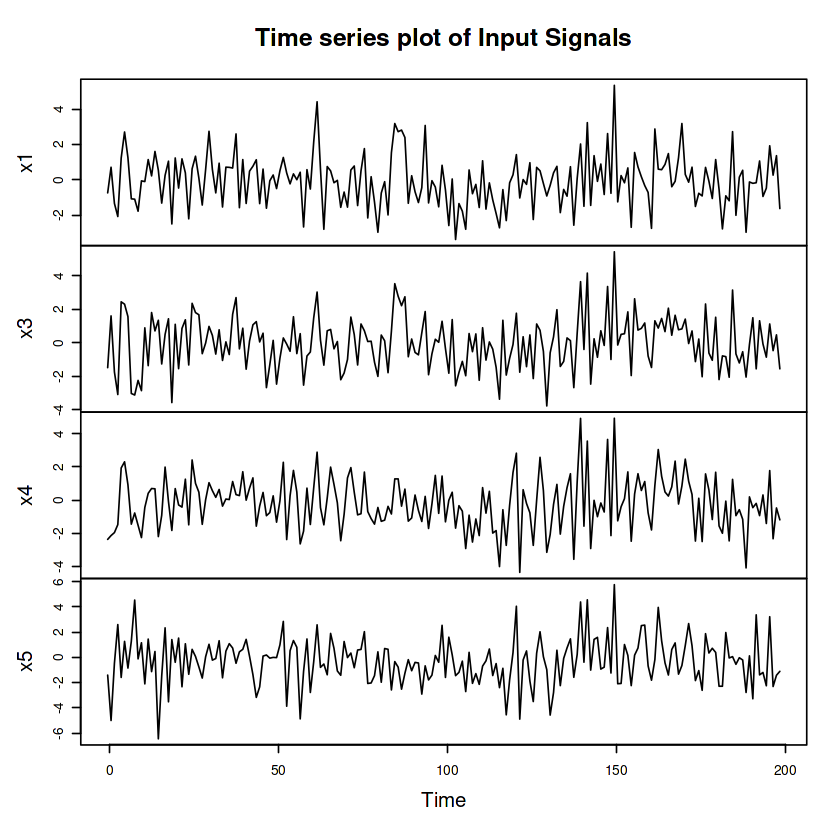

In [5]:
# For input signal time series
# Here we are combining all the inputs signal and making it into a time series objects using ts()
# This is done so that all the input signal plot can be made into a single graph

# Making the input signal matrix into time series object
# Here we set frequency = 1 as with this we are indicating that the observations in the time series are at the same level of granularity, that is at the same unit of time (second).
input_signal.ts <- ts(input_signal, start = c(min(times), max(times)), frequency = 1)

# Creates the combined plot of input signal
plot(input_signal.ts, main = "Time series plot of Input Signals", xlab = "Time", ylab = "Input signal")

The time series plot shows four signals (x1, x3, x4, and x5) fluctuating around a mean of approximately zero. x1 and x3 exhibit moderate variability with no clear trends, though occasional spikes are noticeable. x4 shows slightly larger fluctuations compared to x1 and x3, especially in the latter part of the graph. x5 has the largest range of variation, with more striking peaks and troughs, suggesting volatility. Further statistical analysis would help identify underlying patterns or relationships in these signals.

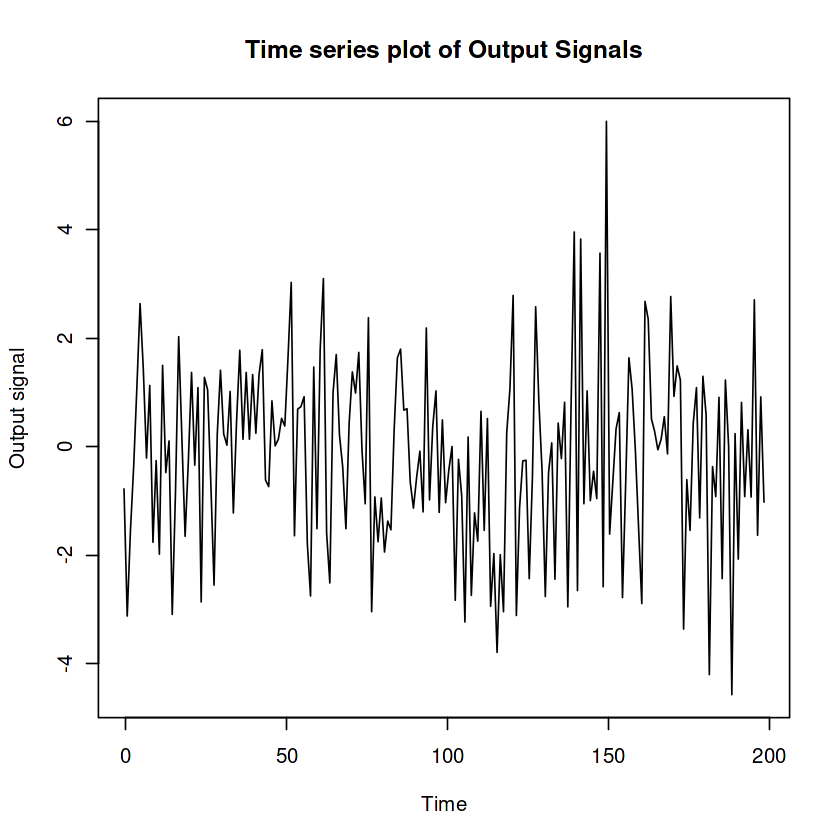

In [6]:
# For output signal time series

# Making the output signal matrix into time series object
output_signal.ts <- ts(output_signal, start = c(min(times), max(times)), frequency = 1)

# Creates the combined plot of output signal
plot(output_signal.ts, main = "Time series plot of Output Signals", xlab = "Time", ylab = "Output signal")

The time series plot of the output signal shows random fluctuations around a mean value of approximately zero, with no visible trends. The variability appears to increase slightly after the midpoint, as evidenced by more frequent spikes. This behaviour indicates higher volatility in the output signal. We will require further analysis to figure out more about the data.

## Task 1.2: Distribution for each brain signal

To further analyse the provided data, we will be using histogram and density plot. Using the histogram we will find how the data is distributed. Along with histogram, we will be using a density plot. Density plot is a variation of histogram with “kernel smoothing”, meaning it is a continuous and smooth version of histogram inferred from a data, where the highest peak is the region with maximum data point.

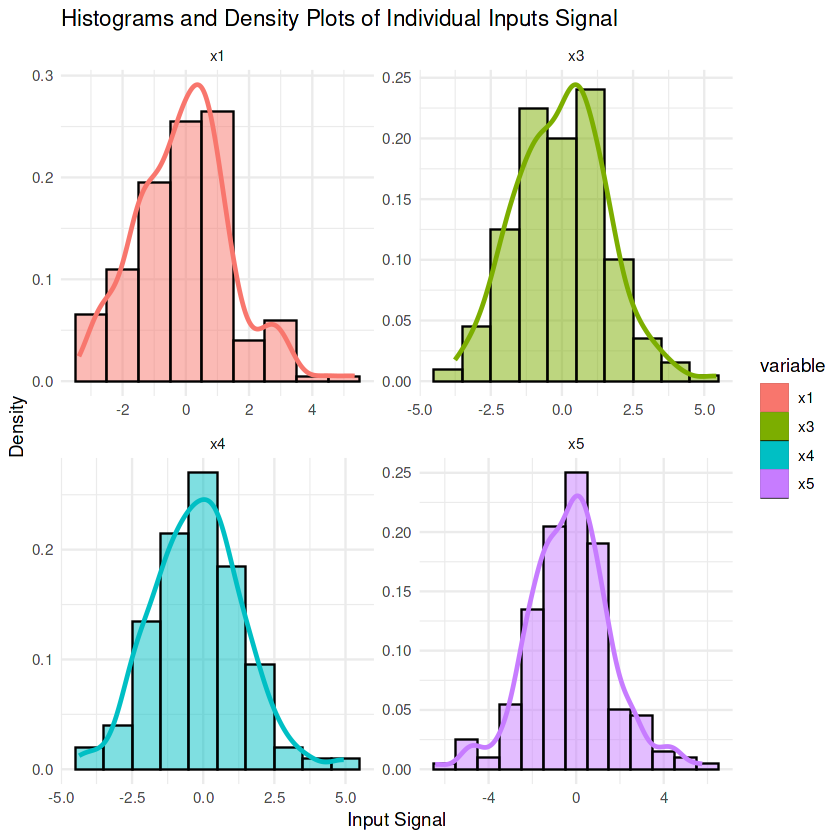

In [7]:
# Combine data into a long format for ggplot2
input_df <- data.frame(
    value = as.vector(as.matrix(input_signal)),
    variable = rep(colnames(input_signal), each = nrow(input_signal))
)

# Plot histogram and density plot for individual input signals
ggplot(input_df, aes(x = value)) +
    geom_histogram(aes(y = after_stat(density), fill = variable), binwidth = 1, alpha = 0.5, color = "black") +
    geom_density(aes(color = variable), linewidth = 1) +
    labs(title = "Histograms and Density Plots of Individual Inputs Signal", x = "Input Signal", y = "Density") +
    theme_minimal() +
    facet_wrap(~ variable, scales = "free", ncol = 2)

From the graph, we can observe that the majority of the data seems to be concentrated around the center. But upon close inspection, we can say that x3, x4 and x5 seem the most symmetrical and normally distributed, centered around 0. But, x1 is very slightly right skewed or positively skewed. The slight positive skewness of x1 suggests that the majority of the data are on the left side whereas the right side has extreme values.

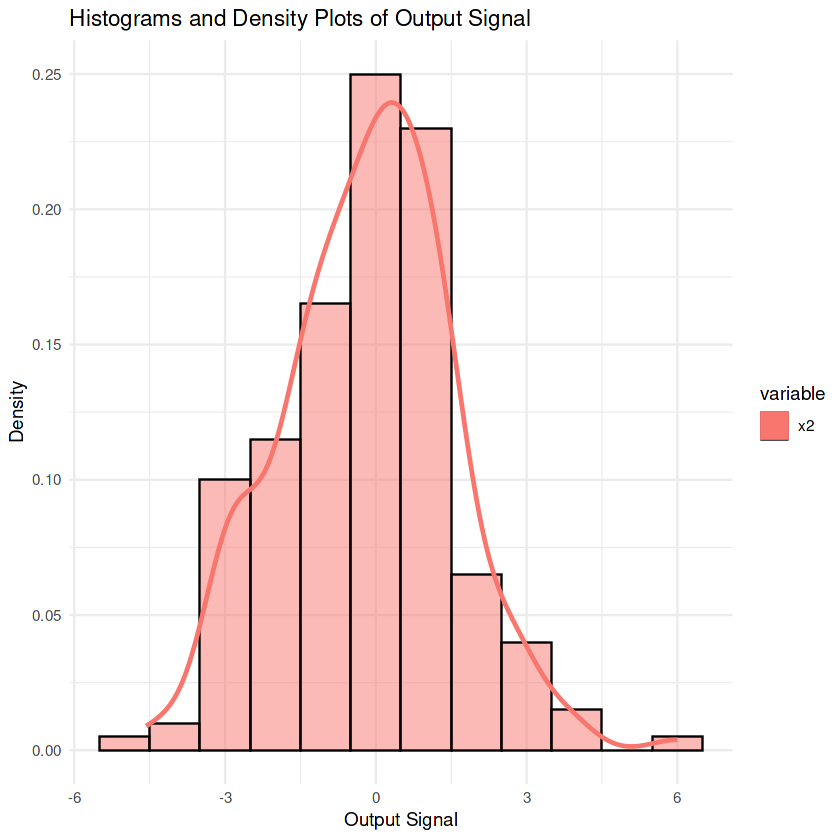

In [8]:
# Combine data into a long format for ggplot2
output_df <- data.frame(
    value = as.vector(as.matrix(output_signal)),
    variable = rep(colnames(output_signal), each = nrow(output_signal))
)

# Plot histogram and density plot for individual input signals
ggplot(output_df, aes(x = value)) +
    geom_histogram(aes(y = after_stat(density), fill = variable), binwidth = 1, alpha = 0.5, color = "black") +
    geom_density(aes(color = variable), linewidth = 1) +
    labs(title = "Histograms and Density Plots of Output Signal", x = "Output Signal", y = "Density") +
    theme_minimal()

The graph of output signal seems to be symmetrical and normally distributed, which implies that the majority of data lies around the center.

## Task 1.3: Correlation and Scatter Plots

To determine correlation between input and output signal, scatter plot can be used where input signal is on x-axis and output signal is on y-axis. Using the scatter plot we can see if there are clusters or patterns in the data, which also helps us determine the outliers and distribution of the data. The correlation is said to be strong if the data is concentrated around the best fit line we have drawn.

In [9]:
# Calculate the correlation between each input signal and the output signal
correlations <- sapply(1:ncol(input_signal), function(i) cor(input_signal[, i], output_signal))

# Print the correlation values
print(correlations)

[1] 0.7489903 0.5417720 0.8478195 0.6880391


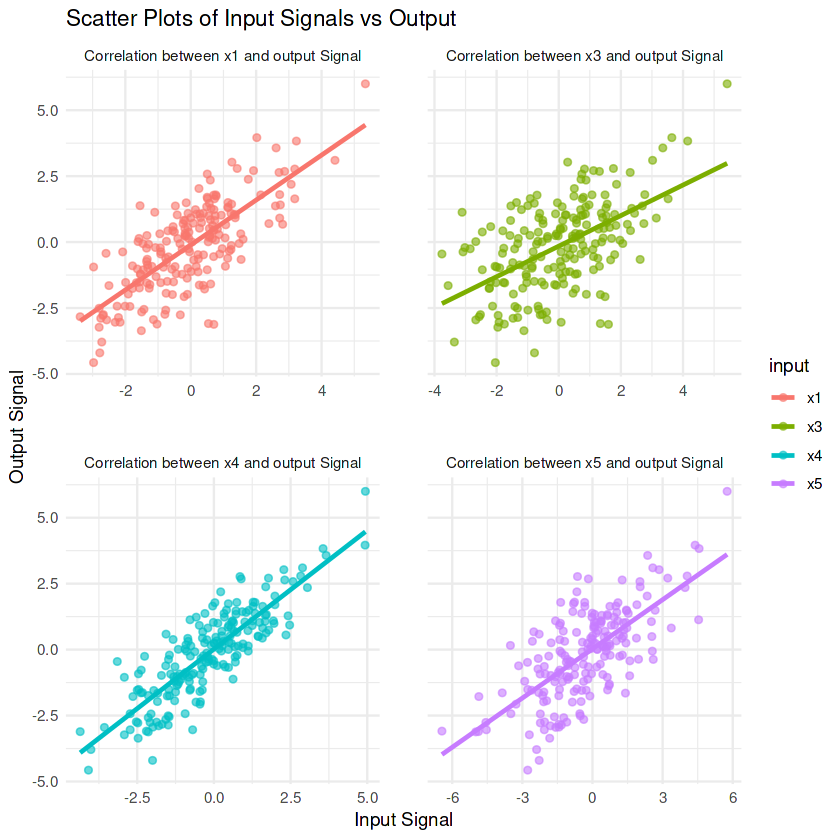

In [10]:
# Create a data frame for ggplot2 (reshape the data for ggplot)
input_output_df <- data.frame(
    value = as.vector(as.matrix(input_signal)),
    input = rep(colnames(input_signal), each = nrow(input_signal)),
    output = as.vector(as.matrix(output_signal))
)

ggplot(input_output_df, aes(x = value, y = output)) +
    geom_point(aes(color = input), alpha = 0.6) +
    geom_smooth(formula = y ~ x, method = "lm", se = FALSE, aes(color = input)) +
    facet_wrap(~ input, scales = "free_x", labeller = 
               labeller(input = c(
                   "x1" = "Correlation between x1 and output Signal", 
                    "x3" = "Correlation between x3 and output Signal", 
                    "x4" = "Correlation between x4 and output Signal", 
                    "x5" = "Correlation between x5 and output Signal"
               ))) +
    labs(title = "Scatter Plots of Input Signals vs Output", x = "Input Signal", y = "Output Signal") +
    theme_minimal() +
    theme(panel.spacing = unit(2, "lines"))

Judging from the graph, we can clearly observe that x4 has the highest correlation with the output signal since it is the one with the most cluster around the best fit line drawn. x1 and x5 also show strong correlation with the output signal, but x3 is the most spread, which is an indication of weak correlation.

# Task 2: Regression – modelling the relationship between signals

In this task, we will be explaining the relation between input and output brain response signals based on the polynomial regression model we have been provided. And, using various statistical calculations, from the 5 given polynomial regression models we are going to determine which model is the best fit.

Model 1: $ y = \theta_1 x_4 + \theta_2 {x_3}^2 + \theta_{bias} $

Model 2: $ y = \theta_1 x_4 + \theta_2 {x_3}^2 + \theta_3 x_5  + \theta_{bias} $

Model 3: $ y = \theta_1 x_3 + \theta_2 x_4 + \theta_3 {x_5}^3 $

Model 4: $ y = \theta_1 x_4 + \theta_2 {x_3}^2 + \theta_3 {x_5}^3 + \theta_{bias} $

Model 5: $ y = \theta_1 x_4 + \theta_2 {x_1}^2 + \theta_3 {x_3}^2 + \theta_{bias} $

## Task 2.1: Estimate Model Parameter using Least Squares

Just from the preliminary data analysis we can not determine which is the most suitable model.

Therefore, we are going to use Least Square Method (LSM) to determine the best fit for the data provided. The method of least squares is a parameter estimation method in regression analysis based on minimizing the sum of the squares of the residuals (a residual being the difference between an observed value and the fitted value provided by a model) made in the results of each individual equation.

The Least Square Method is represented by $ \hat{\theta} $.

$ \hat{\theta} = {(X^T X)}^{-1} X^T y $

where:
    
* X is the matrix of input variables
* y is the vector of output variables
* T represents the transpose of a matrix or vector
* $ \hat{\theta} $ is the estimated value of the model parameters (Least square).


Model 1: $ y = \theta_1 x_4 + \theta_2 {x_3}^2 + \theta_{bias} $

In [11]:
# Estimate model parameter using least squares for model 1
matrix_of_ones <- matrix(1, nrow=nrow(input_signal), ncol=1)

input_model_1 <- cbind(matrix_of_ones, input_signal["x4"], input_signal["x3"]^2)

input_model_1_matrix <- as.matrix(input_model_1)

theta_hat_for_model_1 <- solve(t(input_model_1_matrix) %*% input_model_1_matrix) %*% t(input_model_1_matrix) %*% as.matrix(output_signal)

print(theta_hat_for_model_1)

                        x2
matrix_of_ones -0.12167769
x4              0.88481155
x3              0.05485661


Model 2: $ y = \theta_1 x_4 + \theta_2 {x_3}^2 + \theta_3 x_5  + \theta_{bias} $

In [12]:
# Estimate model parameter using least squares for model 2
input_model_2 <- cbind(matrix_of_ones, input_signal["x4"], input_signal["x3"]^2, input_signal["x5"])

input_model_2_matrix <- as.matrix(input_model_2)

theta_hat_for_model_2 <- solve(t(input_model_2_matrix) %*% input_model_2_matrix) %*% t(input_model_2_matrix) %*% as.matrix(output_signal)

print(theta_hat_for_model_2)

                        x2
matrix_of_ones -0.05929464
x4              0.76073534
x3              0.03927117
x5              0.16073311


Model 3: $ y = \theta_1 x_3 + \theta_2 x_4 + \theta_3 {x_5}^3 $

In [13]:
# Estimate model parameter using least squares for model 3
input_model_3 <- cbind(matrix_of_ones, input_signal["x3"], input_signal["x4"], input_signal["x5"]^3)

input_model_3_matrix <- as.matrix(input_model_3)

theta_hat_for_model_3 <- solve(t(input_model_3_matrix) %*% input_model_3_matrix) %*% t(input_model_3_matrix) %*% as.matrix(output_signal)

print(theta_hat_for_model_3)

                         x2
matrix_of_ones  0.036643292
x3             -0.114608741
x4              0.927307947
x5              0.005279506


Model 4: $ y = \theta_1 x_4 + \theta_2 {x_3}^2 + \theta_3 {x_5}^3 + \theta_{bias} $

In [14]:
# Estimate model parameter using least squares for model 4
input_model_4 <- cbind(matrix_of_ones, input_signal["x4"], input_signal["x3"]^2, input_signal["x5"]^3)

input_model_4_matrix <- as.matrix(input_model_4)

theta_hat_for_model_4 <- solve(t(input_model_4_matrix) %*% input_model_4_matrix) %*% t(input_model_4_matrix) %*% as.matrix(output_signal)

print(theta_hat_for_model_4)

                         x2
matrix_of_ones -0.082086650
x4              0.835911791
x3              0.040640457
x5              0.004980744



Model 5: $ y = \theta_1 x_4 + \theta_2 {x_1}^2 + \theta_3 {x_3}^2 + \theta_{bias} $

In [15]:
# Estimate model parameter using least squares for model 5
input_model_5 <- cbind(matrix_of_ones, input_signal["x4"], input_signal["x1"]^2, input_signal["x3"]^2)

input_model_5_matrix <- as.matrix(input_model_5)

theta_hat_for_model_5 <- solve(t(input_model_5_matrix) %*% input_model_5_matrix) %*% t(input_model_5_matrix) %*% as.matrix(output_signal)

print(theta_hat_for_model_5)

                        x2
matrix_of_ones -0.09919425
x4              0.88614620
x1             -0.03576666
x3              0.07754541


## Task 2.2: Residual Sum of Squares(RSS)

The residual sum of squares (RSS) measures the level of variance in the error term, or residuals, of a regression model. The smaller the residual sum of squares, the better your model fits your data. A value of zero means your model is a perfect fit.

To calculate RSS, we first have to calculate error of every model with the help of $ \hat{\theta} $ that we calculated in Task 2.1 and RSS is mathematically presented as:

$ RSS =  \sum_{i=1}^n {(y_i - x_i \hat{\theta})}^2 $

where:

* n represents the number of observations
* $ y_i $ represents the observed value of the dependent variable for the i-th observation
* $ x_i $ represents the value of the independent variable for the i-th observation
* $ \hat{\theta} $ represents the estimated value of the model parameters (Based in task 2.1)

In [16]:
# RSS of model 1
output_pred_model_1 <- input_model_1_matrix %*% theta_hat_for_model_1

residuals_model_1 <- output_signal - output_pred_model_1

RSS_model_1 <- sum(residuals_model_1^2)

print(RSS_model_1)

[1] 151.9524


In [17]:
# RSS of model 2
output_pred_model_2 <- input_model_2_matrix %*% theta_hat_for_model_2

residuals_model_2 <- output_signal - output_pred_model_2

RSS_model_2 <- sum(residuals_model_2^2)

print(RSS_model_2)

[1] 142.9336


In [18]:
# RSS of model 3
output_pred_model_3 <- input_model_3_matrix %*% theta_hat_for_model_3

residuals_model_3 <- output_signal - output_pred_model_3

RSS_model_3 <- sum(residuals_model_3^2)

print(RSS_model_3)

[1] 149.3799


In [19]:
# RSS of model 4
output_pred_model_4 <- input_model_4_matrix %*% theta_hat_for_model_4

residuals_model_4 <- output_signal - output_pred_model_4

RSS_model_4 <- sum(residuals_model_4^2)

print(RSS_model_4)

[1] 148.4341


In [20]:
# RSS of model 5
output_pred_model_5 <- input_model_5_matrix %*% theta_hat_for_model_5

residuals_model_5 <- output_signal - output_pred_model_5

RSS_model_5 <- sum(residuals_model_5^2)

print(RSS_model_5)

[1] 150.2694


| Model | Rss |
| --- | --- | 
| Model 1 | 151.9524 |
| Model 2 | 142.9336 | 
| Model 3 | 149.3799 | 
| Model 4 | 148.4341 |
| Model 5 | 150.2694 |

## Task 2.3: Log-Likelihood Function

Now we need to find how well measured value fits the sample data of the provided model. To find that, we will be using Log-Likelihood Function, using the RSS obtained from Task 2.2. A likelihood method is a measure of how well a particular model fits the data.

Mathematically, it is defined by:

$ \ln p(D|\hat{\theta}) = {{-\frac n 2}\ln(2\pi)} {{-\frac n 2}\ln({\hat{\sigma}}^2)} {{-\frac n {2{\hat{\sigma}}^2}} RSS} $

In [21]:
# Calculating length of the output signal
n <- nrow(output_signal)

# Log-Likelihood function of model 1

error_variance_model_1 <- RSS_model_1 / (n-1)

likelihood_model_1 <- -(n/2)*(log(2*pi))-(n/2)*(log(error_variance_model_1))-(1/(2*error_variance_model_1))*RSS_model_1

print(sprintf("Error variance of model 1: %0.4f", error_variance_model_1))
print(sprintf("Log likelihood function of model 1: %0.4f", likelihood_model_1))

[1] "Error variance of model 1: 0.7636"
[1] "Log likelihood function of model 1: -256.3140"


In [22]:
# Log-Likelihood function of model 2

error_variance_model_2 <- RSS_model_2 / (n-1)

likelihood_model_2 <- -(n/2)*(log(2*pi))-(n/2)*(log(error_variance_model_2))-(1/(2*error_variance_model_2))*RSS_model_2

print(sprintf("Error variance of model 2: %0.4f", error_variance_model_2))
print(sprintf("Log likelihood function of model 2: %0.4f", likelihood_model_2))

[1] "Error variance of model 2: 0.7183"
[1] "Log likelihood function of model 2: -250.1952"


In [23]:
# Log-Likelihood function of model 3

error_variance_model_3 <- RSS_model_3 / (n-1)

likelihood_model_3 <- -(n/2)*(log(2*pi))-(n/2)*(log(error_variance_model_3))-(1/(2*error_variance_model_3))*RSS_model_3

print(sprintf("Error variance of model 3: %0.4f", error_variance_model_3))
print(sprintf("Log likelihood function of model 3: %0.4f", likelihood_model_3))

[1] "Error variance of model 3: 0.7507"
[1] "Log likelihood function of model 3: -254.6065"


In [24]:
# Log-Likelihood function of model 4

error_variance_model_4 <- RSS_model_4 / (n-1)

likelihood_model_4 <- -(n/2)*(log(2*pi))-(n/2)*(log(error_variance_model_4))-(1/(2*error_variance_model_4))*RSS_model_4

print(sprintf("Error variance of model 4: %0.4f", error_variance_model_4))
print(sprintf("Log likelihood function of model 4: %0.4f", likelihood_model_4))

[1] "Error variance of model 4: 0.7459"
[1] "Log likelihood function of model 4: -253.9714"


In [25]:
# Log-Likelihood function of model 5

error_variance_model_5 <- RSS_model_5 / (n-1)

likelihood_model_5 <- -(n/2)*(log(2*pi))-(n/2)*(log(error_variance_model_5))-(1/(2*error_variance_model_5))*RSS_model_5

print(sprintf("Error variance of model 5: %0.4f", error_variance_model_5))
print(sprintf("Log likelihood function of model 5: %0.4f", likelihood_model_5))

[1] "Error variance of model 5: 0.7551"
[1] "Log likelihood function of model 5: -255.2002"


| Model | Error Variance | Log-Likelihood function |
| --- | --- | --- |
| Model 1 | 0.7636 | -256.3140 |
| Model 2 | 0.7183 | -250.1952 |
| Model 3 | 0.7507 | -254.6065 |
| Model 4 | 0.7459 | -253.9714 |
| Model 5 | 0.7551 | -255.2002 |

Model 2 has the lowest error variance (0.7183) and the highest log-likelihood (−250.1952).

Based on the provided metrics, Model 2 is the best model as it has the smallest error variance and the highest log-likelihood value.

## Task 2.4: Akaike Information Criterion and Bayesian Information Criteria

The **Akaike Information Criteria/Criterion (AIC)** is a method used in statistics to compare the relative quality of different models for a given dataset. The AIC method helps in selecting the best model out of a bunch by penalizing models that are overly complex. Models having lower AIC scores are preferred as they achieve a good balance between fitting the data and avoiding overfitting.

$ AIC = 2k - 2\ln p(D|\hat{\theta}) $

where,
* k is number of parameters
* $ \hat{\theta} $ is the likelihood function (Task 2.3)

The **Bayesian Information Criterion (BIC)** is a statistical measure used for model selection from a finite set of models. It is based on the likelihood function and incorporates a penalty term for the number of parameters in the model to avoid overfitting. BIC helps in identifying the model that best explains the data while balancing model complexity and goodness of fit.

$ BIC = k \ln (n) - 2\ln p(D|\hat{\theta}) $

where,
* $ p(D|\hat{\theta}) $ is the likelihood (Task 2.3).
* k is the number of parameters in the model.
* n is the number of data points.

In [26]:
# AIC and BIC of model 1
k_model_1 <- length(input_model_1)

AIC_model_1 <- 2 * k_model_1 - 2 * likelihood_model_1

BIC_model_1 <- k_model_1 * log(n) - 2 * likelihood_model_1

print(sprintf("AIC of model 1: %0.4f", AIC_model_1))
print(sprintf("BIC of model 1: %0.4f", BIC_model_1))

[1] "AIC of model 1: 518.6279"
[1] "BIC of model 1: 528.5229"


In [27]:
# AIC and BIC of model 2
k_model_2 <- length(input_model_2)

AIC_model_2 <- 2 * k_model_2 - 2 * likelihood_model_2

BIC_model_2 <- k_model_2 * log(n) - 2 * likelihood_model_2

print(sprintf("AIC of model 1: %0.4f", AIC_model_2))
print(sprintf("BIC of model 1: %0.4f", BIC_model_2))

[1] "AIC of model 1: 508.3905"
[1] "BIC of model 1: 521.5837"


In [28]:
# AIC and BIC of model 3
k_model_3 <- length(input_model_3)

AIC_model_3 <- 2 * k_model_3 - 2 * likelihood_model_3

BIC_model_3 <- k_model_2 * log(n) - 2 * likelihood_model_3

print(sprintf("AIC of model 1: %0.4f", AIC_model_3))
print(sprintf("BIC of model 1: %0.4f", BIC_model_3))

[1] "AIC of model 1: 517.2130"
[1] "BIC of model 1: 530.4063"


In [29]:
# AIC and BIC of model 4
k_model_4 <- length(input_model_4)

AIC_model_4 <- 2 * k_model_4 - 2 * likelihood_model_4

BIC_model_4 <- k_model_4 * log(n) - 2 * likelihood_model_4

print(sprintf("AIC of model 1: %0.4f", AIC_model_4))
print(sprintf("BIC of model 1: %0.4f", BIC_model_4))

[1] "AIC of model 1: 515.9427"
[1] "BIC of model 1: 529.1360"


In [30]:
# AIC and BIC of model 5
k_model_5 <- length(input_model_5)

AIC_model_5 <- 2 * k_model_5 - 2 * likelihood_model_5

BIC_model_5 <- k_model_5 * log(n) - 2 * likelihood_model_5

print(sprintf("AIC of model 1: %0.4f", AIC_model_5))
print(sprintf("BIC of model 1: %0.4f", BIC_model_5))

[1] "AIC of model 1: 518.4004"
[1] "BIC of model 1: 531.5936"


| Model | AIC | BIC |
| --- | --- | --- |
| Model 1 | 518.6279 | 528.5229 |
| Model 2 | 508.3905 | 521.5837 |
| Model 3 | 517.2130 | 530.4063 |
| Model 4 | 515.9427 | 529.1360 |
| Model 5 | 518.4004 | 531.5936 |

Model 2 has the lowest AIC (508.3905) and lowest BIC (521.5837).

Based on both AIC and BIC, Model 2 is the best model. It achieves the optimal trade-off between model fit and simplicity.

## Task 2.5: Distribution of Model Prediction Errors using Q-Q Plot

The quantile-quantile or 𝑞−𝑞 plot is an exploratory graphical device used to check the validity of a distributional assumption for a data set. In general, the basic idea is to compute the theoretically expected value for each data point based on the distribution in question. If the data indeed follow the assumed distribution, then the points on the 𝑞−𝑞 plot will fall approximately on a straight line.

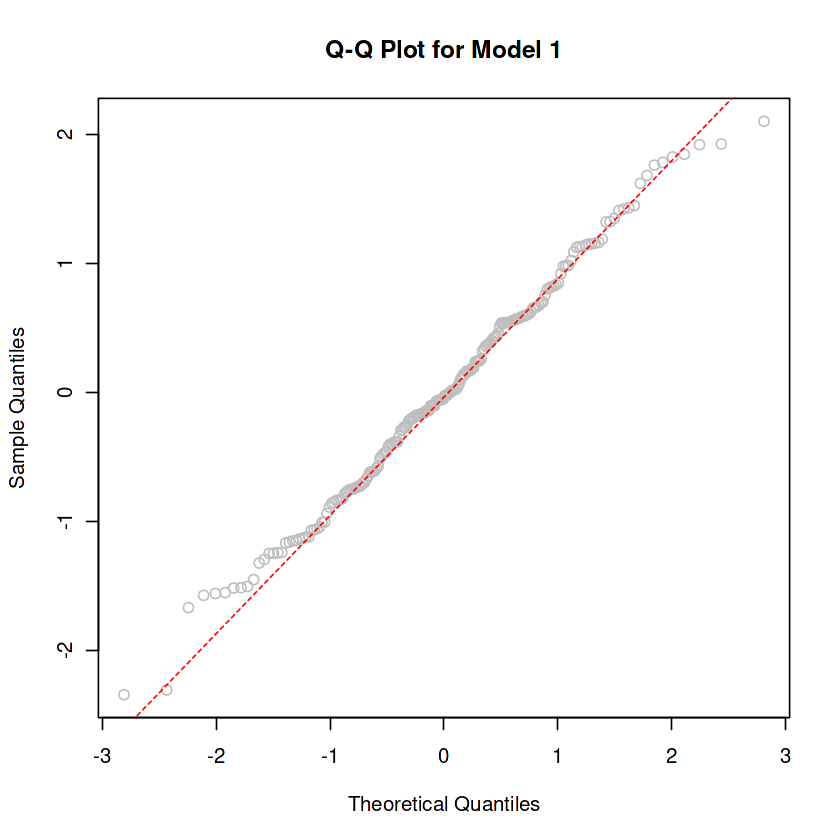

In [31]:
# Q-Q plot of model 1
qqnorm(t(residuals_model_1),col = "grey", main = "Q-Q Plot for Model 1" )
qqline(residuals_model_1, col = "red", lwd = 1,lty = 2)

Q-Q plot for model 1 shows that most of the data follows Q-Q line (red color) thus we can say data follows a normal distribution.

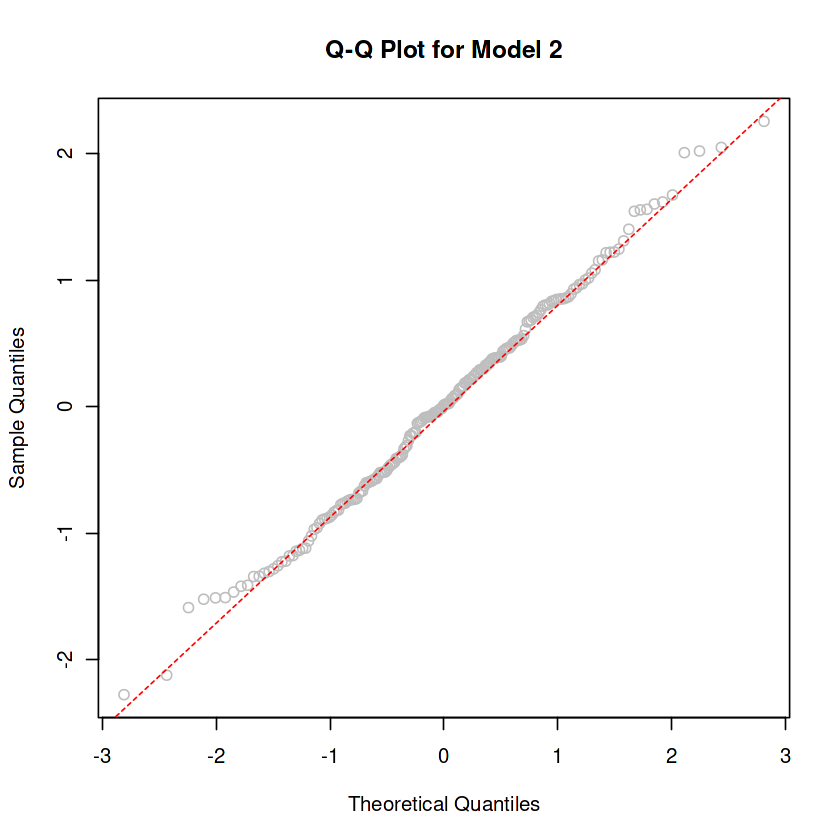

In [32]:
# Q-Q plot of model 2
qqnorm(t(residuals_model_2),col = "grey", main = "Q-Q Plot for Model 2" )
qqline(residuals_model_2, col = "red", lwd = 1,lty = 2)

Q-Q plot for model 2 shows that most of the data follows Q-Q line (red color) thus we can say data follows a normal distribution.

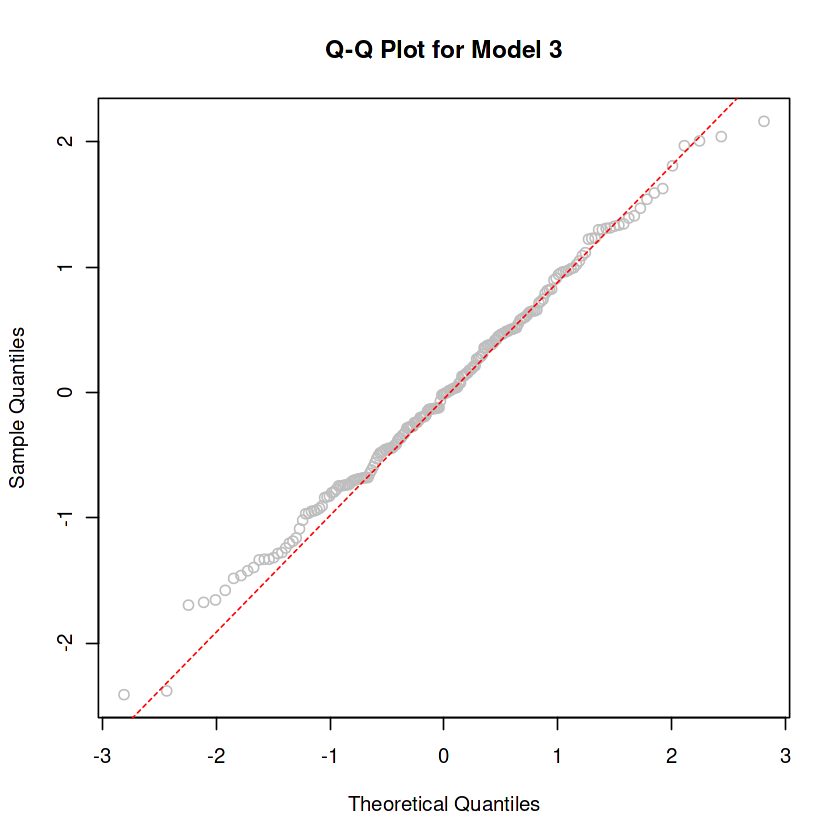

In [33]:
# Q-Q plot of model 3
qqnorm(t(residuals_model_3),col = "grey", main = "Q-Q Plot for Model 3" )
qqline(residuals_model_3, col = "red", lwd = 1,lty = 2)

Q-Q plot for model 3 shows that most of the data follows Q-Q line (red color) thus we can say data follows a normal distribution.

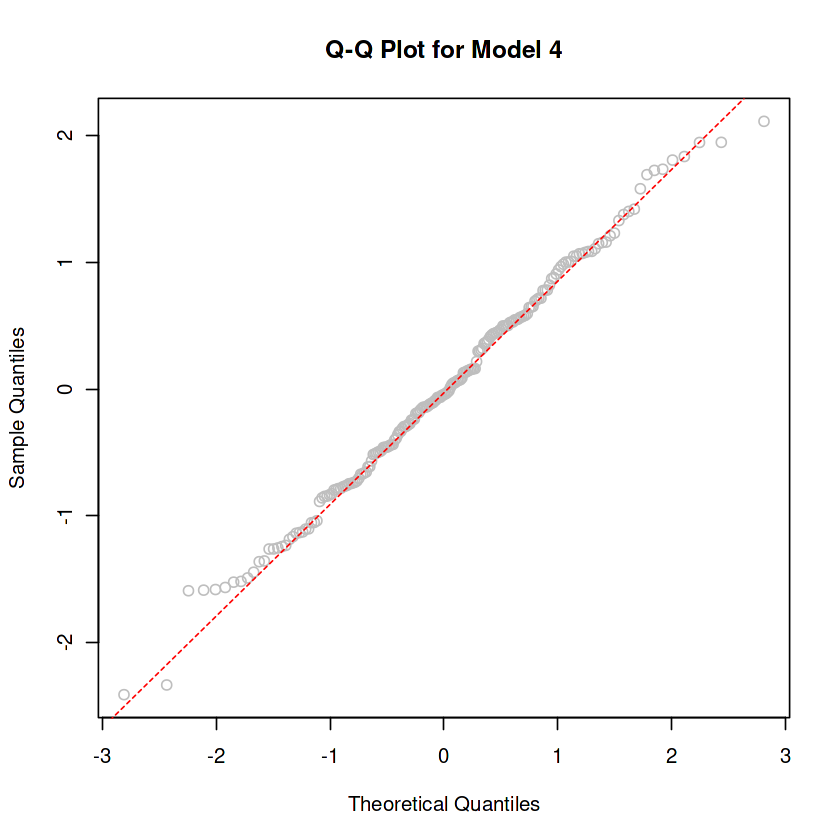

In [34]:
# Q-Q plot of model 4
qqnorm(t(residuals_model_4),col = "grey", main = "Q-Q Plot for Model 4" )
qqline(residuals_model_4, col = "red", lwd = 1,lty = 2)

Q-Q plot for model 4 shows that most of the data follows Q-Q line (red color) thus we can say data follows a normal distribution.

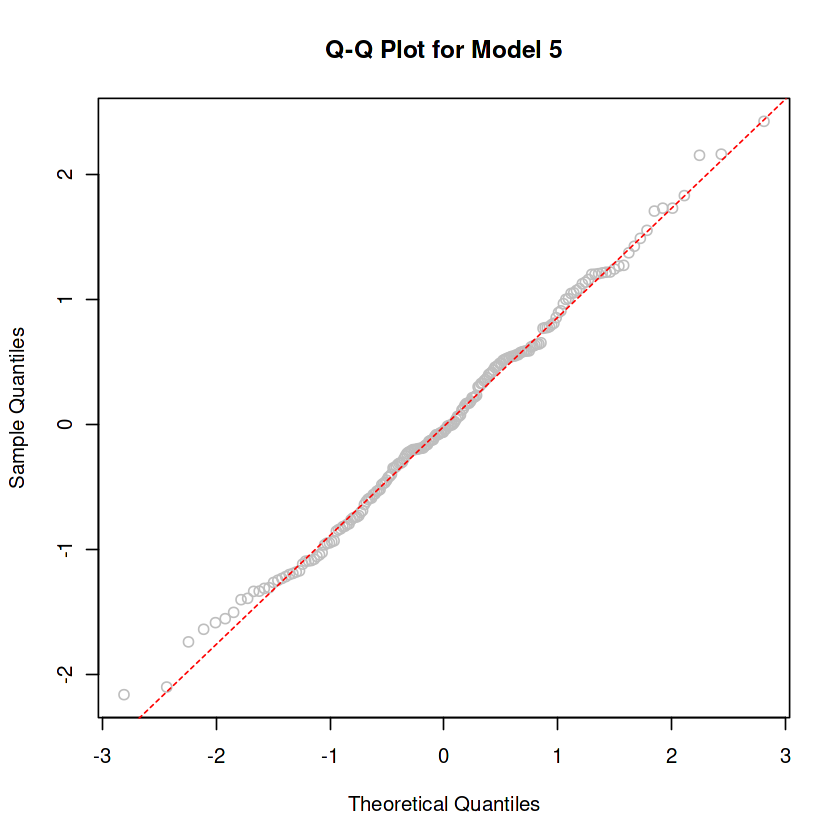

In [35]:
# Q-Q plot of model 5
qqnorm(t(residuals_model_5),col = "grey", main = "Q-Q Plot for Model 5" )
qqline(residuals_model_5, col = "red", lwd = 1,lty = 2)

Q-Q plot for model 5  shows that most of the data follows Q-Q line (red color) thus we can say data follows a normal distribution.

## Task 2.6: Selecting Best Regression Model

The model comparison has been done. Now, we selected the best fit model by using all the analysis we have done so far. Here, we try to select the model with the lowest RSS, lowest Error Variance, highest log-likelihood and lastly lowest AIC and BIC values.

| Model   | RSS       | Error Variance | Log-Likelihood | AIC       | BIC       | Q-Q Plot              |
|---------|-----------|----------------|----------------|-----------|-----------|-----------------------|
| Model 1 | 151.9524  | 0.7636         | -256.3140      | 518.6279  | 528.5229  | Normally distributed  |
| Model 2 | 142.9336  | 0.7183         | -250.1952      | 508.3905  | 521.5837  | Normally distributed  |
| Model 3 | 149.3799  | 0.7507         | -254.6065      | 517.2130  | 530.4063  | Normally distributed  |
| Model 4 | 148.4341  | 0.7459         | -253.9714      | 515.9427  | 529.1360  | Normally distributed  |
| Model 5 | 150.2694  | 0.7551         | -255.2002      | 518.4004  | 531.5936  | Normally distributed  |


From all the calculations done so far, following are the observations,

- RSS: Model 2 has the lowest RSS (142.9336), indicating the best fit to the data.
- Error Variance: Model 2 also has the lowest error variance (0.7183), further confirming its accuracy.
- Log-Likelihood: Model 2 has the highest (least negative) log-likelihood (-250.1952), showing the best likelihood of observing the data under this model.
- AIC and BIC: Model 2 has the lowest AIC (508.3905) and BIC (521.5837), suggesting it balances fit and complexity most effectively.

Model 2 is the best model because it minimizes RSS and error variance, maximizes log-likelihood, and has the lowest AIC and BIC values. These metrics indicate that Model 2 provides the best trade-off between goodness-of-fit and model simplicity.

Therefore, model 2 will be selected, as it has been found to be the best fit model for the provided data.


## Task 2.7: Splitting Data for Test and Train for Selected Model 2

From all the analysis done so far, we have concluded that model 2 to be the best candidate.

Now, we split the data into training and testing with 70/30 split respectively, since it provides the best ratio between learning and estimating.

In [36]:
# Spliting data into training and testing

# Input signal split
split_input_signal <- initial_split(input_signal, prop = .7)

training_input_signal <- training(split_input_signal)
testing_input_signal <- testing(split_input_signal)

# Output signal split
split_output_signal <- initial_split(output_signal, prop = .7)

training_output_signal <- training(split_output_signal)
testing_output_signal <- testing(split_output_signal)


### Task 2.7.1: Estimate model parameters use the training dataset

Using what we did in Task 2.1, we will estimate the Least square for the training dataset.

Model 2: $ y = \theta_1 x_4 + \theta_2 {x_3}^2 + \theta_3 x_5  + \theta_{bias} $

In [37]:
matrix_of_ones_training <- matrix(1, nrow=nrow(training_input_signal),ncol=1) 

training_input_model_2 <- cbind(matrix_of_ones_training, training_input_signal["x4"], training_input_signal["x3"]^2, training_input_signal["x5"])

training_input_model_2_matrix <- as.matrix(training_input_model_2)

training_theta_hat_for_model_2 <- solve(t(training_input_model_2_matrix) %*% training_input_model_2_matrix) %*% t(training_input_model_2_matrix) %*% as.matrix(training_output_signal)

print(training_theta_hat_for_model_2)

                                 x2
matrix_of_ones_training -0.19063192
x4                      -0.09718140
x3                       0.01570104
x5                       0.05392535


### Task 2.7.2: Compute the model’s output/prediction on the testing data

Using what we did in Task 2.1, we will estimate the RSS.

In [38]:
testing_output_pred_model_2 <- as.matrix(testing_input_signal) %*% training_theta_hat_for_model_2

### Task 2.7.3: Computing 95% confidence interval and visualizaing

A 95% confidence test is used to estimate a range (called the confidence interval) within which the true population parameter (e.g., mean, proportion) is likely to fall, with 95% certainty.

In [39]:
# Perform a one-sample t-test on the dataset `testing_output_pred_model_2` to test if the mean 
# is significantly different from 700 (null hypothesis: mean = 700).
# The test is two-sided (checks for differences in both directions) and uses a 95% confidence level.
t_test_result <- t.test(testing_output_pred_model_2, mu = 700, alternative = "two.sided", conf.level = 0.95)     

# Print the results of the t-test, including test statistic, p-value, and confidence interval
print(t_test_result)



	One Sample t-test

data:  testing_output_pred_model_2
t = -16003, df = 59, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 700
95 percent confidence interval:
 -0.08537441  0.08967771
sample estimates:
  mean of x 
0.002151648 



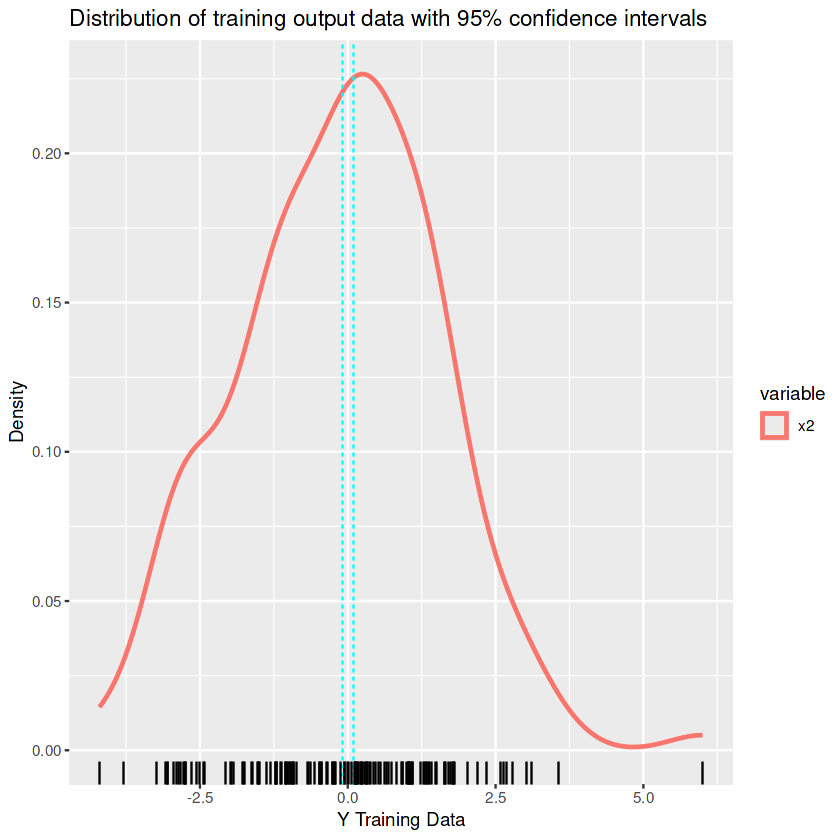

In [40]:
# Setting CI value based on t-test at the time of run
C_I1 <- t_test_result$conf.int[1]

C_I2 <- t_test_result$conf.int[2]

training_output_signal_df <- data.frame(
    value = as.vector(as.matrix(training_output_signal)),
    variable = rep(colnames(training_output_signal), each = nrow(training_output_signal))
)

ggplot(data = training_output_signal_df, aes(x = value)) +
    geom_density(aes(color = variable), linewidth=1) +
    geom_vline(xintercept = C_I1, col = "cyan", linetype = "dashed") +
    geom_vline(xintercept = C_I2, col = "cyan", linetype = "dashed") +
    geom_rug()+
    ggtitle("Distribution of training output data with 95% confidence intervals")+
    xlab("Y Training Data") +
    ylab("Density")

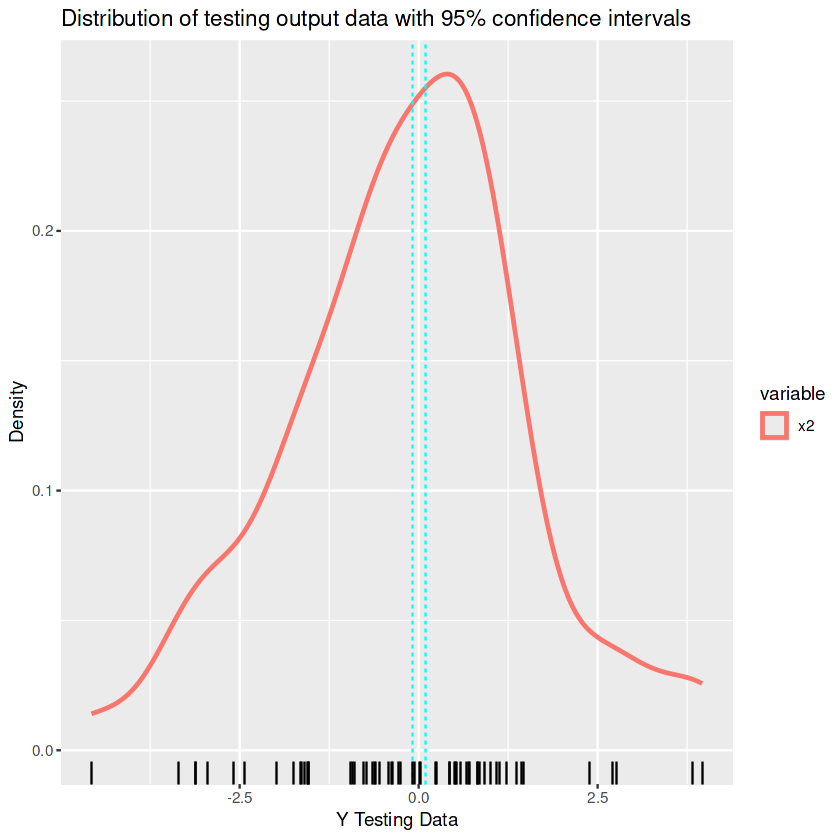

In [41]:
testing_output_signal_df <- data.frame(
    value = as.vector(as.matrix(testing_output_signal)),
    variable = rep(colnames(testing_output_signal), each = nrow(testing_output_signal))
)

ggplot(data = testing_output_signal_df, aes(x = value)) +
    geom_density(aes(color = variable), linewidth=1) +
    geom_vline(xintercept = C_I1, col = "cyan", linetype = "dashed") +
    geom_vline(xintercept = C_I2, col = "cyan", linetype = "dashed") +
    geom_rug()+
    ggtitle("Distribution of testing output data with 95% confidence intervals")+
    xlab("Y Testing Data") +
    ylab("Density")

The probability of the population mean value being between -0.004123997 and +0.146775052 standard deviations (z-scores) from the sample mean is 95%.

Accordingly, there is a 5% chance that the population mean lies outside of the upper and lower confidence interval

# Task 3: Approximate Bayesian Computation (ABC)

Bayesian statistics are methods that allow for the systematic updating of beliefs in the evidence of new data. The fundamental theorem that these methods are built upon is known as Bayes’ theorem. This says, given two events A and B , the conditional probability of A given that B is true is expressed as

$ P(A|B) = \frac { P(B|A) P(A) } { P(B) } $

where:

* P(A|B) is posterior probability
* P(B|A) is likelihood function
* P(A) is prior probability
* P(B) is new probability

## Task 3.1: Compute 2 parameter posterior distributions

We will now compute 2 parameter posterior distributions, where 2 parameters with largest absolute value in our least squares estimation (Task 2.1) of the selected model 2. Then we will keep all the other parameters of our model as constant.

In [42]:
# Creator vector of theta_hat of selected model 2 and sorting them to find out two largest absolute value and printing it

numbers <- c(theta_hat_for_model_2)
sorted_numbers <- sort(abs(numbers), decreasing=TRUE)
largest_two_values <- sorted_numbers[1:2]
print(largest_two_values)

[1] 0.7607353 0.1607331


In [43]:
print(theta_hat_for_model_2)

theta_4 <- largest_two_values[1]
theta_5 <- largest_two_values[2]

theta_bias <- theta_hat_for_model_2[1]
theta_3 <- theta_hat_for_model_2[3]

                        x2
matrix_of_ones -0.05929464
x4              0.76073534
x3              0.03927117
x5              0.16073311


So from the calculation, we found that  x4 (0.7607353) is the largest followed by x5 (0.1607331) which is the second largest. Therefore, we will be selecting x4 and x5 as parameters.

## Task 3.2: Using Uniform distribution as prior, around the estimated parameter values for 2 parameters

Uniform distribution refers to a type of probability distribution in which all outcomes are equally likely. Probability distributions can help us decide the probability of a future event.

Now we determine the range of the prior distribution.

In [44]:
# Define the prior ranges for the two largest parameters (with some tolerance)
# For example, use +/- 10% of the estimated value as the range for the uniform prior

prior_range_1 <- c(theta_4 * 0.9, theta_4 * 1.1)  # Uniform prior for first largest parameter
prior_range_2 <- c(theta_5 * 0.9, theta_5 * 1.1)  # Uniform prior for second largest parameter

Here, we are using +/- 10% of the estimated value as the range for the uniform prior.

## Task 3.3: Draw samples from Uniform Prior and perform rejection ABC

For some particular problems, we may find that we can not express the likelihood, or it is very costly to compute it. In such a situation, we use Approximate Bayesian Computation (ABC). 

ABC, is a method used when there is no explicit expression for the likelihood, but has a parameterized simulator which is capable of generating synthetic data. The simulator has one or more parameters that are unknown but what we want is which set of parameters generates data that are close enough to the observed data. But from the perspective of the ABC method, the simulator is a black-box, where we provide the parameter values and then get the simulated data.

In [45]:
# To create the tolerance threshold
epsilon <- RSS_model_2 * 4  # Multiply by 4 to increase the tolerance (allowing more accepted samples)


# Set the number of iterations for the sampling process
num <- 1000
# Initialize a counter to keep track of how many samples are accepted
counter <- 0

# Initialize storage for accepted samples
accepted_x4 <- c()
accepted_x5 <- c()

for (i in 1:num) {
   # Sample from the uniform prior for the two largest parameters
    prior_x4 <- runif(1, min = prior_range_1[1], max = prior_range_1[2])  # Sample for first largest parameter
    prior_x5 <- runif(1, min = prior_range_2[1], max = prior_range_2[2])  # Sample for second largest parameter

    # Combine the samples into a new parameter vector
    new_theta_hat <- matrix(c(prior_x4, prior_x5, theta_bias, theta_3))

    # Simulate new predictions
    new_output_hat <- input_model_2_matrix %*% new_theta_hat 

    # Calculate new RSS
    new_RSS <- sum((output_signal - new_output_hat)^2)

    # Accept the sample if the new RSS is below the tolerance
    if (new_RSS < epsilon) {
        accepted_x4 <- c(accepted_x4, prior_x4)
        accepted_x5 <- c(accepted_x5, prior_x5)
        counter <- counter + 1
    }
}

# Create a data frame of accepted samples
abc_result <- data.frame(f_value = accepted_x4, s_value = accepted_x5)

# Printing the observations
print(paste("Tolerance Threshold: ", epsilon))
print(paste("Number of accepted samples:", nrow(abc_result)))

[1] "Tolerance Threshold:  571.734311617544"
[1] "Number of accepted samples: 903"


Here, we checked whether RSS values(new_RSS) is smaller than threshold value(epsilon). From the condition, new_RSS < epsilon, we are trying to select all the simulated data that are close enough to the observed data.

## Task 3.4: Plot joint and marginal posterior distribution for those 2 parameters

Finally we will visualize the joint and marginal posterior distribution of the parameters using histogram and scatter plot.

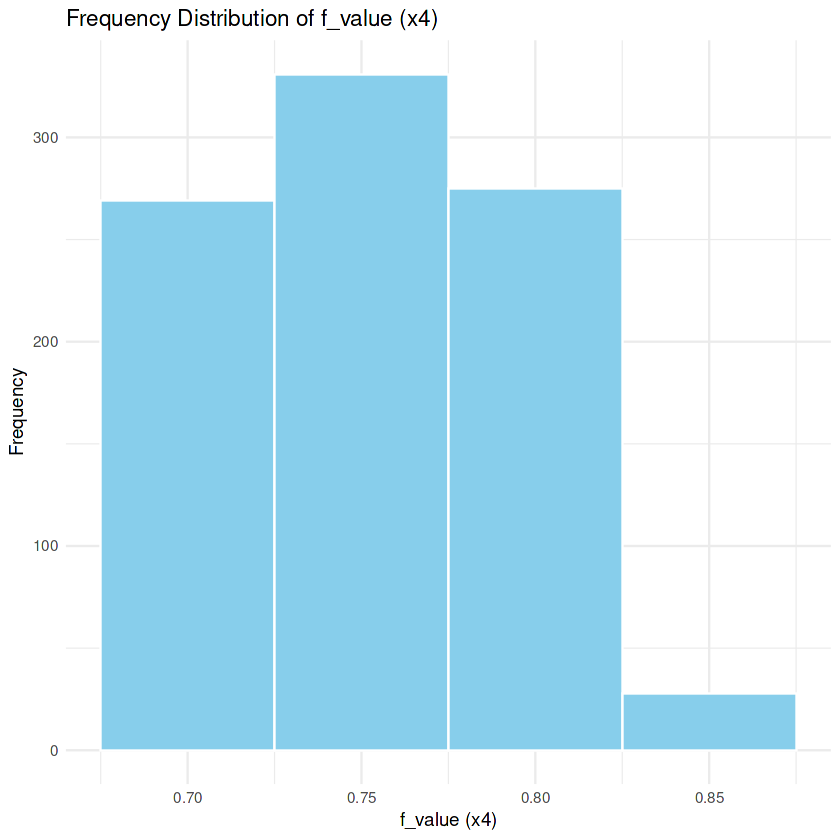

In [46]:
# Frequency distribution for f_value (x4)
ggplot(abc_result, aes(x = f_value)) +
  geom_histogram(binwidth = 0.05, fill = "skyblue", color = "white") +
  labs(title = "Frequency Distribution of f_value (x4)",
       x = "f_value (x4)", 
       y = "Frequency") +
  theme_minimal()

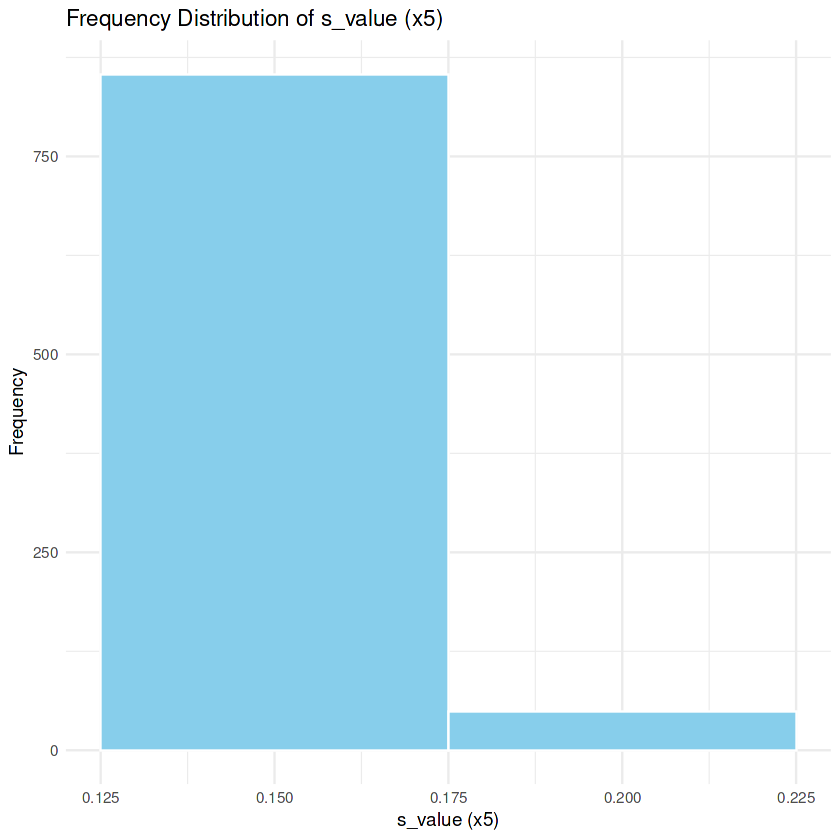

In [47]:
# Frequency distribution for f_value (x4)
ggplot(abc_result, aes(x = s_value)) +
  geom_histogram(binwidth = 0.05, fill = "skyblue", color = "white") +
  labs(title = "Frequency Distribution of s_value (x5)",
       x = "s_value (x5)", 
       y = "Frequency") +
  theme_minimal()

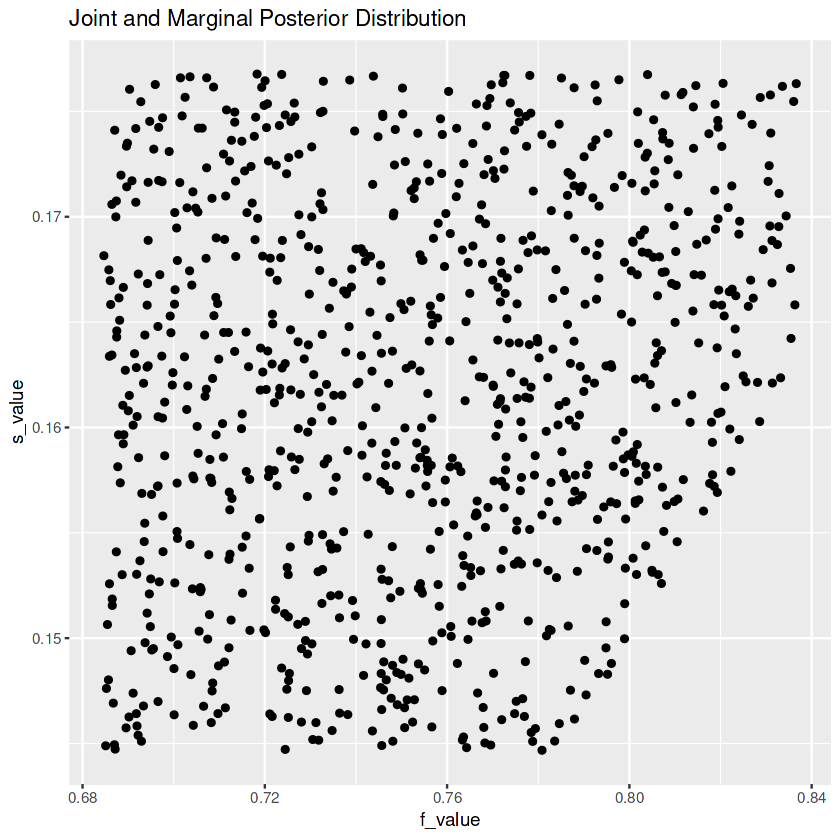

In [48]:
# Plot the scatter plot using and hiding legends
ggplot(abc_result, aes(x=f_value, y=s_value)) +
  geom_point()+
  theme(legend.position="bottom")+ # show legend in bottom
  theme(legend.title = element_blank())+ # hide legend word
   #guides(color=FALSE)+ # Uncomment to hide legend
  ggtitle("Joint and Marginal Posterior Distribution")

By plotting the f_value and s_value, we get the visual representation of the parameters that provided the good fit between the simulated and observed data.

# Conclusion

In this analysis, we used Time Series Analysis, Data Distribution, and Correlation techniques to examine the brain response signal data. The output signal (x2) exhibited more random fluctuation, while the input signals (x1, x3, x4, x5) showed similar results. X4 displayed slightly larger fluctuations than x1 and x3 but x5 had the highest variations.

We employed several statistical methods, including the least squares approach, residual sum of squares, log-likelihood function, Akaike Information Criterion (AIC), and Bayesian Information Criterion (BIC), to evaluate five different estimator models. Based on the AIC and BIC values, Model 2 emerged as the best in terms of both fit and complexity. Additionally, the QQ-plot analysis confirmed that all models followed the theoretical distribution.

For the Approximate Bayesian Computation (ABC) rejection method, we focused on two key parameters: x4 and x5. The "epsilon" parameter was introduced to define the tolerance for variance between the observed and simulated data. This new parameter allowed us to generate values within a specified range over multiple iterations. Each iteration resulted in updated values for new theta hat and output theta hat, which were computed to track the changes in the model’s output.

# References

ecorrector. (17 August, 2023). “Preliminary Data: Unveiling the Early Stages of Research and How to Disseminate It.” Retrieved from https://ecorrector.com/preliminary-data-unveiling-the-early-stages-of-research-and-how-to-disseminate-it/

Wikipedia. (15 September, 2024). “Linear least squares.”. Retrieved from https://en.wikipedia.org/wiki/Linear_least_squares

Investopedia. (10 February, 2024). “Residual Sum of Squares (RSS): What It Is and How to Calculate It”. Retrieved from https://www.investopedia.com/terms/r/residual-sum-of-squares.asp

Statisticshowto. “Log Likelihood Function”. Retrieved from https://www.statisticshowto.com/log-likelihood-function/

Muhammad Imdad Ullah. (24 July, 2024). “Akaike Information Criteria: A Comprehensive Guide”. Retrieved from https://itfeature.com/regression/selection/akaike-information-criteria/

Geeksforgeeks. (29 July, 2024). “Bayesian Information Criterion (BIC)”. Retrieved from https://www.geeksforgeeks.org/bayesian-information-criterion-bic/

David Lane. (24 April, 2022). “Q-Q Plots”. Retrieved from https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Introductory_Statistics_(Lane)/08%3A_Advanced_Graphs/8.01%3A_Q-Q_Plots

Saul McLeod, PhD. (11 October, 2023). “Confidence Intervals Explained: Examples, Formula & Interpretation”. Retrieved from https://www.simplypsychology.org/confidence-interval.html

Investopedia. (26 June, 2024). “Uniform Distribution: Definition, How It Works, and Example”. Retrieved from https://www.investopedia.com/terms/u/uniform-distribution.asp

Tom Leyshon. (14 March, 2021). “The ABCs of Approximate Bayesian Computation”. Retrieved from https://towardsdatascience.com/the-abcs-of-approximate-bayesian-computation-bfe11b8ca341
